In [161]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision.transforms import v2
import random


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [4]:
train_df = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')

<Axes: xlabel='label'>

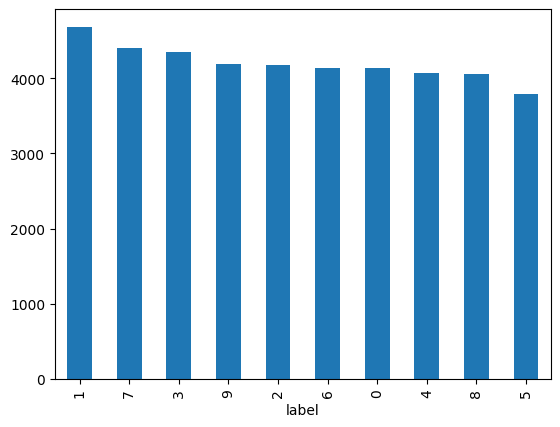

In [8]:
train_df['label'].value_counts().plot.bar()

In [14]:
torch.from_numpy(train_df.filter(train_df.columns[1:]).iloc[0].values).reshape(28, 28).shape

torch.Size([28, 28])

In [64]:
train_df.head(3)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


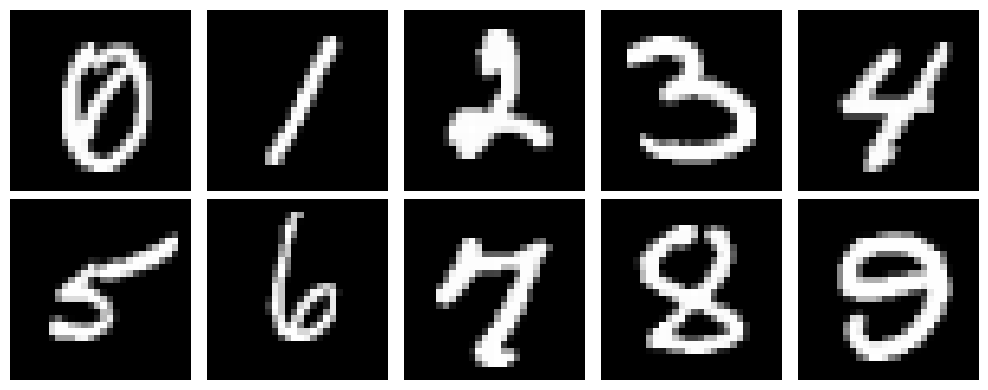

In [162]:
images = train_df.sample(frac=1).reset_index(drop=True).groupby(by='label').first().reset_index(drop=False).filter(train_df.columns[1:]).values.reshape(10, 28, 28)
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(images[i], cmap='gray')
    ax.axis('off')

plt.tight_layout() 
plt.show()

In [143]:
label = torch.tensor(train_df['label'])
train = torch.tensor(np.array(train_df.drop(['label'], axis = 1)), dtype=torch.float32).reshape(len(train_df), 1, 28, 28)

In [144]:
X_train, X_test, y_train, y_test = train_test_split(train, label ,test_size = 0.20,random_state = 42, stratify=label)
len(X_train), len(X_test), len(y_train), len(y_test)

(33600, 8400, 33600, 8400)

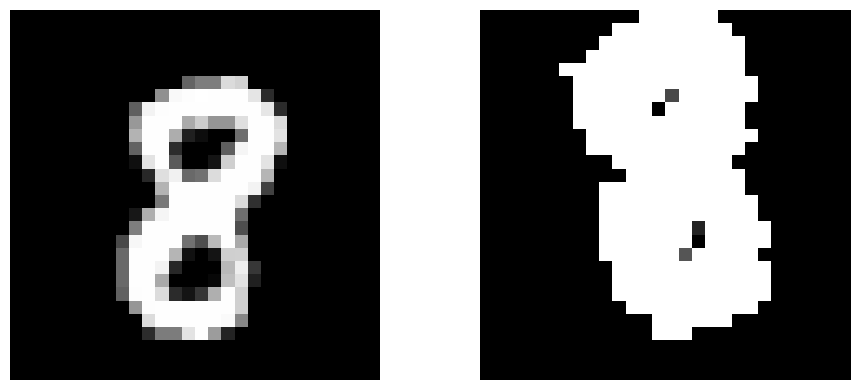

In [260]:
index = random.randint(0, len(X_train))
image =  X_train[index]


# Define transformations
transform = v2.Compose([# Convert image to PyTorch tensor,
    v2.RandomResizedCrop(scale=(0.7, 1), size=(28, 28), antialias=True),
    v2.RandomHorizontalFlip(p=0.3),
    v2.Normalize((0,), (1,)),
    v2.RandomApply([v2.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.2, hue=0.1)], p=0.6),
    v2.RandomAffine(30, scale=(0.95, 1))
])

# Assuming 'image' is your 28x28 image
processed_image = transform(image)
images = [image, processed_image]
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(images[i].numpy().reshape(28, 28), cmap='gray')
    ax.axis('off')

plt.tight_layout() 
plt.show()